### Spectrometer Control Notebook

Make sure you followed the instructions in the Camera Control Notebook and were able to record a spectrum with your Lego Spectrometer 📈.

In [19]:
import numpy as np
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt

from picamera import PiCamera
from PIL import Image, ImageDraw
from time import sleep, strftime
from IPython.display import clear_output

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

### Routine `takePicture()`

To make things easy, we define a routine to take an image with the Raspberry Pi Camera. The camera you have has a maximum resolution of 2592 x 1944 pixels. The options are set for the spectrometer setup. Note we rotate the image 270 degrees.

In [7]:
def takePicture(shutter):
    
    print("Initialising camera")
    camera = PiCamera()
    stream = io.BytesIO()
    try:
        # Full camera resolution is 2592 x 1944 - we run at 1/4 resolution 
        camera.resolution = (648, 486)        
        camera.framerate= 5
        camera.rotation = 270
        camera.iso = 800
        camera.shutter_speed = shutter
        camera.awb_mode = 'off'
        camera.awb_gains = (1, 1)

        print("Allowing camera to warmup")
        sleep(1)
        print("Capturing image")

        camera.capture(stream, format='jpeg')
        stream.seek(0)
        raw = Image.open(stream)
    finally:
        camera.close()
    return raw

### Trying it out

Now let's capture an image and display it. Note that the argument shutter specifies the time to expose the image in micro-seconds - so 1,000,000 is one second. the maximum exposure the camera can do is 6,000,000 or 6 seconds.

Initialising camera
Allowing camera to warmup
Capturing image


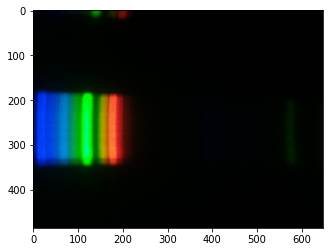

In [12]:
shutter = 100000
image = takePicture(shutter)

plt.imshow(image)  # This will show the captured image

If you see an image - woohoo 🎉🥳. You connected the camera correctly and the code is working. Try different exposure times.

### Cropping the image

Next we need to crop the image to just include the area showing the spectrum. We will first add a rectange to the image to show the current area. The crop region is given by the top left and bottom right points.

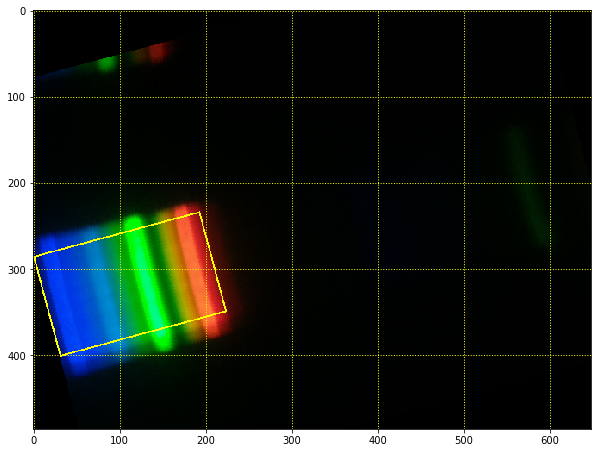

In [23]:
def drawRectangle(img,crop):
    temp = img.copy() # Making a copy to keep our raw image without the lines :)
    draw = ImageDraw.Draw(temp)
    draw.rectangle(crop, outline=(255, 255, 0), width=2)
    return temp

crop=[0,200,200,320]
tmp=drawRectangle(image,crop)
tmp2=tmp.rotate(15.)
plt.imshow(tmp2)

ax = plt.gca()
ax.grid(color='yellow', linestyle='dotted', linewidth=1)

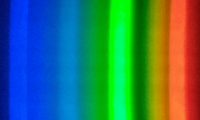

In [11]:
def imageCrop(img,crop):
    return image.crop(crop)

cropped = imageCrop(image,crop)
cropped

And here is the image we will now process and use as our spectrum 😎

In [27]:
def getSpectrum(processed):
    spectrum = np.asarray(processed)
    spectrum = np.average(spectrum[0], axis=1)
    spectrum = spectrum-(0.9*min(spectrum))  # Subtract baseline
    spectrum = spectrum*(200/max(spectrum))  # Normalize to 200
    
    return spectrum

In [25]:
def adjustBrightness(image):
    pixels = np.asarray(image)
    maxcol = [pixels[:,:,0].max(),pixels[:,:,1].max(),pixels[:,:,2].max()]
    factor = int(255 / max(maxcol))
    print ('Brightness factor : ', factor)
    
    return factor*pixels

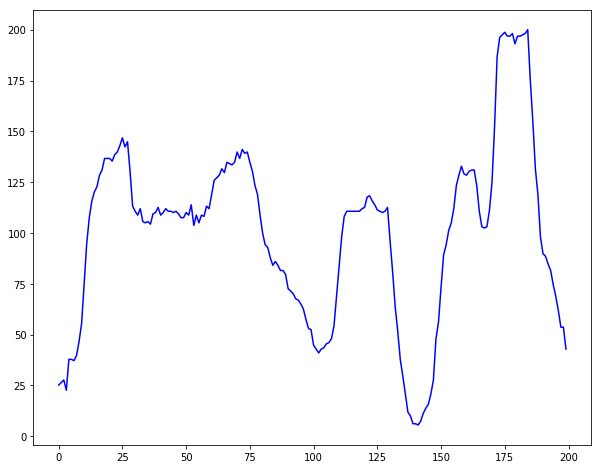

In [29]:
spectrum=getSpectrum(cropped)
plt.plot(spectrum, color='blue')

Brightness factor :  1


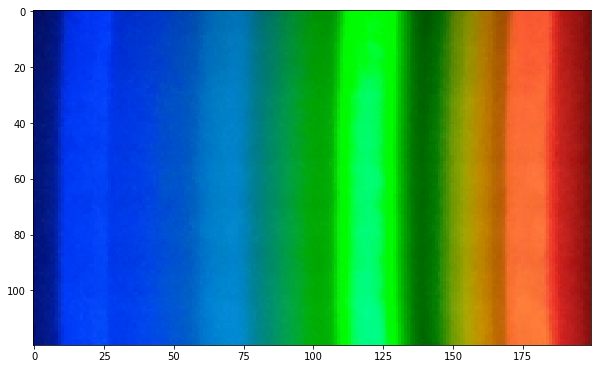

In [31]:
adjusted=adjustBrightness(cropped)
plt.imshow(adjusted)